<table style="background-color: transparent;">
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%" align="center"><font size="7" color="#f25625">Computación Cuántica</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="4" color="black">Temas Selectos de Ingeniería en Computación III</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="4" color="black">2025-2</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="6" color="#f25625">Laboratorio 8: Quantum Machine Learning II</font></td>
    </tr>
</table>

<p style="text-align:right; font-weight:bold;">Autora: Claudia Zendejas-Morales</p>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\mymatrix}[2]{\left[ \begin{array}{#1} #2\end{array} \right]} $
$ \newcommand{\myvector}[1]{\mymatrix{c}{#1}} $

## Contenido

1. [Quantum Machine Learning](#1)
   1. [Algoritmos Variacionales](#1.1)
2. [Qiskit Machine Learning](#2)
   1. [Ejemplo: Clasificación](#2.1)
   2. [Ejemplo: Regresión](#2.2)
   3. [QNN híbrida](#2.3)

<a id="1"></a>
# 1. Quantum Machine Learning

La idea básica es que queremos combinar conceptos de **Machine Learning** y **Computación Cuántica**

- Machine Learning: aprender patrones a partir de algunos datos de entrenamiento
- Computación Cuántica: uso de recursos mecánicos cuánticos para resolver problemas computacionales potencialmente más eficientemente

Podemos clasificar los tipos de ML/QML en las cuatro categorías siguientes:

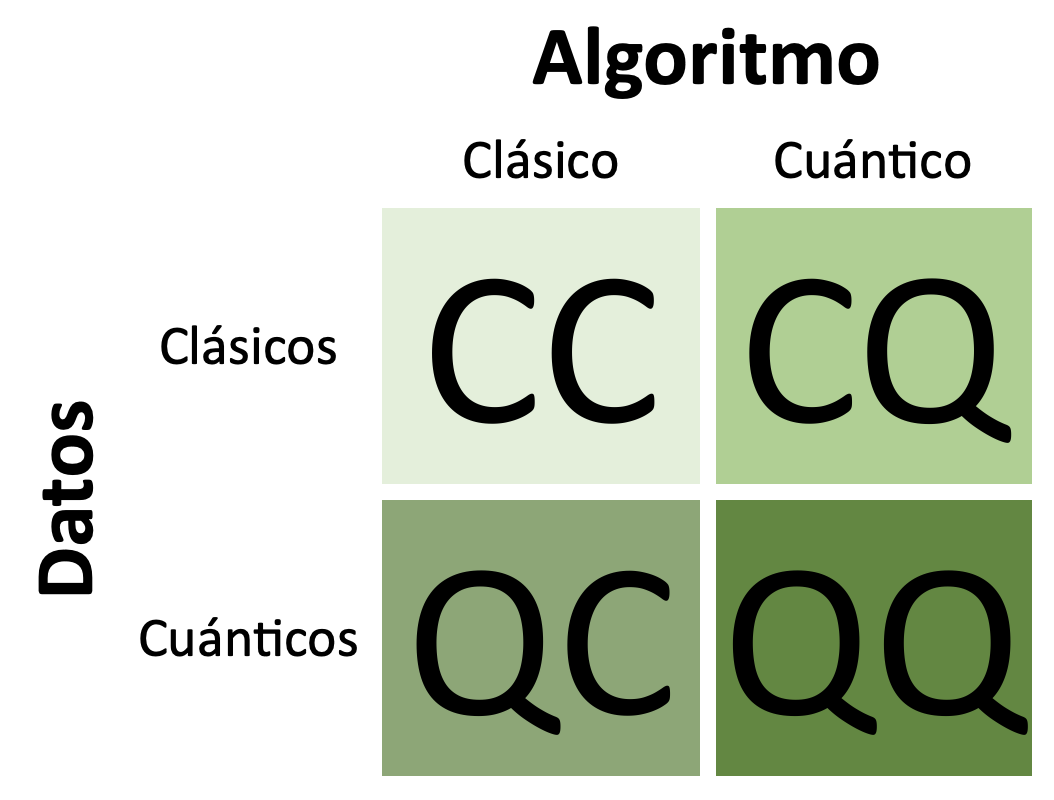

<a id="1.1"></a>
## 1.1. Algoritmos Variacionales

Los **algoritmos variacionales** son una clase de métodos utilizados en _computación cuántica_ para resolver problemas de optimización, simulación y otras tareas complejas. Estos algoritmos combinan lo mejor de los enfoques clásicos y cuánticos, aprovechando las capacidades de las computadoras cuánticas de manera efectiva, incluso con el hardware cuántico ruidoso disponible actualmente.

- Los algoritmos variacionales son híbridos porque combinan componentes clásicos y cuánticos. Una parte del algoritmo se ejecuta en una computadora cuántica, y otra parte se ejecuta en una computadora clásica.
- La computadora cuántica se utiliza para preparar y medir estados cuánticos, mientras que la computadora clásica se utiliza para ajustar los parámetros del circuito cuántico basado en los resultados de las mediciones.


Un par de los primeros artículos que propusieron **circuitos variacionales como modelos supervisados de machine learning cuántico**: [Farhi y Neven (2018)](https://arxiv.org/abs/1802.06002), así como [Schuld et al. (2018)](https://arxiv.org/abs/1804.00633).

<div align="center">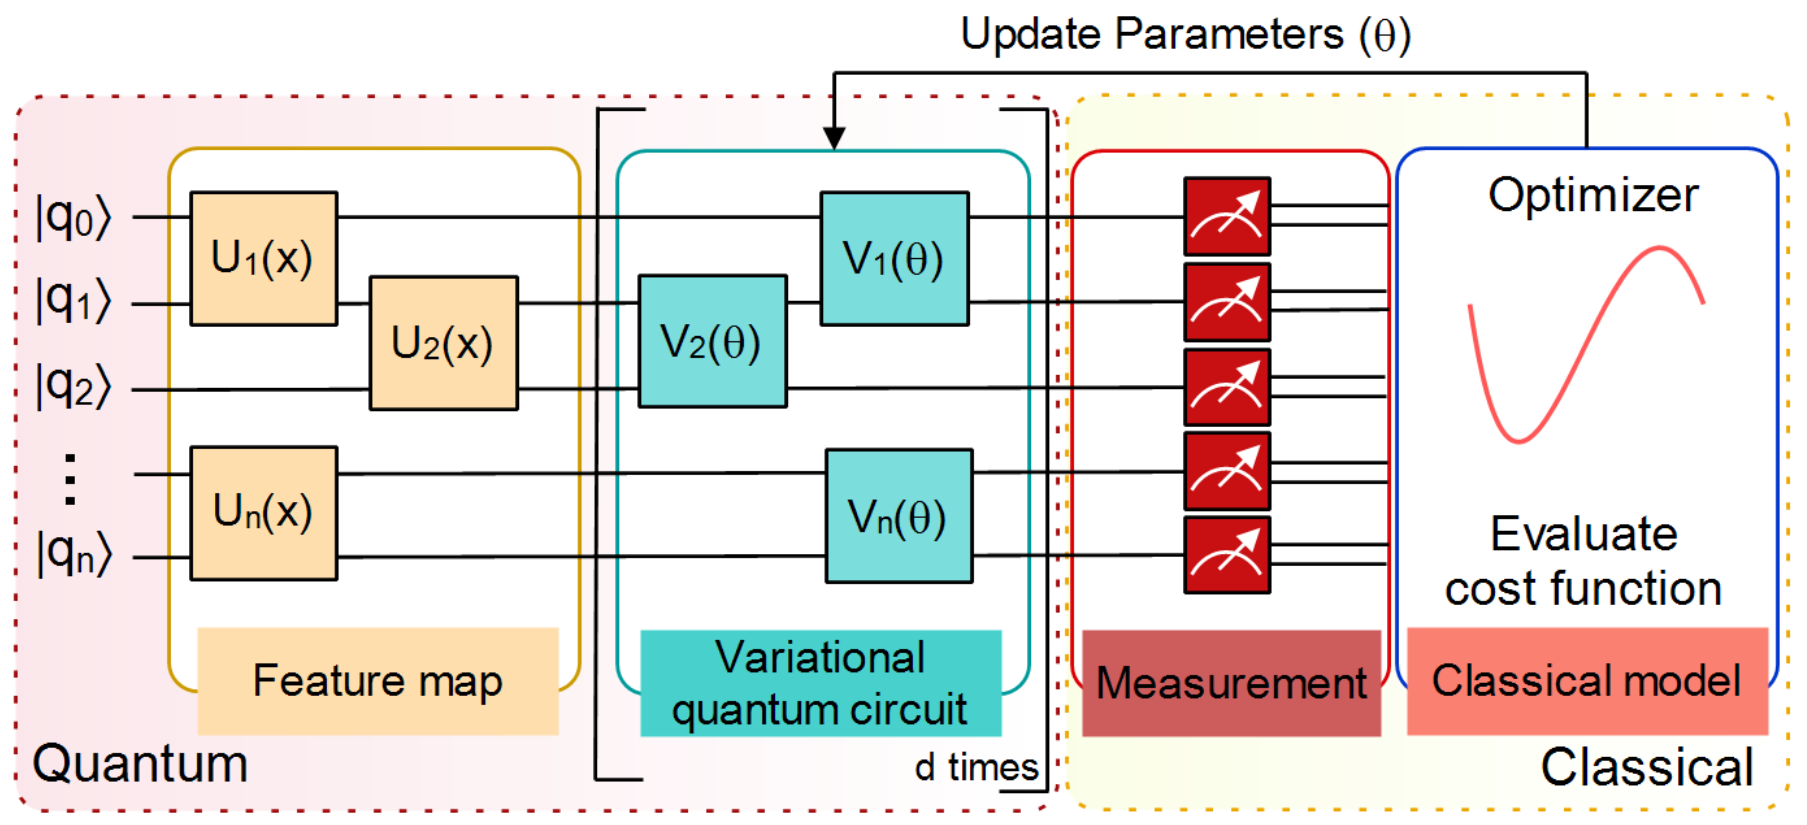

<a id="2"></a>
# 2. Qiskit Machine Learning

> **Qiskit Machine Learning** presenta bloques de construcción computacionales fundamentales, como kernels cuánticos y redes neuronales cuánticas, que se utilizan en diferentes aplicaciones, incluidas la clasificación y la regresión. Por un lado, este paquete es muy fácil de usar y permite a los usuarios crear rápidamente un prototipo de un primer modelo sin conocimientos profundos de computación cuántica. Por otro lado, Qiskit Machine Learning es muy flexible y los usuarios pueden ampliarlo fácilmente para respaldar la investigación de vanguardia en QML.

Qiskit Machine Learning nos proporciona una serie de clases que nos ayudan a resolver problemas con los modelos de clasificación y regresión, por ejemplo `NeuralNetworkClassifier` y `NeuralNetworkRegressor`.

Ambas clases toman como entrada una red neuronal cuántica y la utilizan dependiendo del contexto específico. En ambos casos se debe proporcionar un objeto variacional preconfigurado para mayor comodidad, el Clasificador Cuántico Variacional (Variational Quantum Classifier, `VQC`) y el Regresor Cuántico Variacional (Variational Quantum Regressor, `VQR`).

## Instalación e importaciones

El paquete de Qiskit Machine Learning se debe instalar por separado, se debe tener cuidado con la compatibilidad de versiones, `qiskit-machine-learning` siempre estará un poco atrás de la última versión de `qiskit`.

    pip install qiskit-machine-learning

$$ $$

In [ ]:
#!pip install qiskit-machine-learning==0.8.0             # versión recomendada Mayo 2025

Este código funciona con:
- Qiskit: 1.3.2
- Qiskit Machine Learning: 0.8.0

In [ ]:
import qiskit
import qiskit_machine_learning

print('Versión de Qiskit:                 ', qiskit.version.get_version_info())
print('Versión de Qiskit Machine Learning:', qiskit_machine_learning.version.get_version_info())

El código a continuación necesita las siguientes clases:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

import warnings
warnings.filterwarnings('ignore') 

algorithm_globals.random_seed = 4567890    # para reproducibilidad de resultados

<a id="2.1"></a>
## 2.1 Clasificación

Prepararemos un conjunto de datos de clasificación simple, generando $20$ valores muestra, cada uno es una tupla $(x_1, x_2)$ y definiendo su resultado $y$ dependiendo de si su suma es mayor a $0$ o no, asignando las etiquetas $\{1, 0\}$ respectivamente en la variable `y01`.

En la variable `y_one_hot` se guarda la codificación [one-hot](https://en.wikipedia.org/wiki/One-hot) correspondiente.

En la variable `y` se reetiquetan las muestras con valores $\{-1, +1\}$, los cuales son usados para decidir de qué color se mostrará la muestra en la gráfica, los valores con la etiqueta $+1$ son los que están por encima de la línea $x=-y$ y los de etiqueta $-1$ son los que están por debajo de dicha línea.

In [ ]:
num_inputs = 2                                             # cantidad de entradas (primera capa de la red neuronal)

num_samples = 20                                           # cantidad de muestras para entrenar la red neuronal

X = 2*algorithm_globals.random.random([num_samples, num_inputs]) - 1
                                                           # de manera aleatoria creamos los valores que entran a la capa 1
                                                           # estos son dos valores (inputs) por cada muestra (x1, x2)
                                                           # (valores entre -1 y 1)

y01 = 1*(np.sum(X, axis=1) >= 0)                           # si la suma de los dos valores (de cada muestra) es >= 0
                                                           # (es decir, están arriba de la línea x=-y en el plano)
                                                           # entonces lo clasificamos con la etiqueta '1', caso contrario
                                                           # con la etiqueta '0', así los valores de y01 ∈ {0, 1}
                                                           

y = 2*y01-1                                                # en esta variable reetiquetamos con: y ∈ {-1, +1}

y_one_hot = np.zeros((num_samples, 2))                     # variable para la codificación one-hot ∈ {[1,0], [0,1]}

for i in range(num_samples):                               # generamos los valores one-hot de cada muestra usando y01
    y_one_hot[i, y01[i]] = 1                               # si el valor en y01[i] = 0, entonces y_one_hot_i = [1, 0]
                                                           # pero si y01[i] = 1, entonces y_one_hot_i = [0, 1]

    
for x, y_target in zip(X, y):                              # iteramos sobre las muestras y sus respectivas etiquetas
    if y_target == 1:                                      # si se trata de una muestra etiquetada con '+1'
        plt.plot(x[0], x[1], 'bo')                         # la dibujamos en azul
    else:                                                  # si la muestra tiene un resultado con la etiqueta '-1'
        plt.plot(x[0], x[1], 'go')                         # entonces la dibujamos en verde


plt.plot([-1, 1], [1, -1], '--', color='black')            # dibujamos la gráfica con la línea x = -y
plt.show()                                                 # mostramos la gráfica

### Clasificación con un `EstimatorQNN`

Primero mostramos cómo se puede usar un `EstimatorQNN` (hereda de `NeuralNetwork`) para la clasificación dentro de una `NeuralNetworkClassifier`. En este contexto, se espera que `EstimatorQNN` devuelva una salida unidimensional en $\left[-1,+1\right]$. Esta solo funciona para la clasificación binaria y asignamos las dos clases a $\{-1,+1\}$. Esta clase necesita un [mapa de características](https://computersciencewiki.org/index.php/Feature_maps_(Activation_maps)) (Feature Map) y un [ansatz](https://en.wikipedia.org/wiki/Ansatz) (Circuito Variacional).

$$ $$

Un **feature map** (mapa de características) es una técnica utilizada para codificar datos clásicos en un estado cuántico. Su objetivo es transformar los datos de entrada en un espacio de características (feature space) más elevado donde los datos pueden ser procesados por algoritmos cuánticos de manera más efectiva.

El `ZZFeatureMap` de Qiskit es un ejemplo específico de un _feature map_. Este mapa de características utiliza una combinación de compuertas Hadamard y compuertas de fase para codificar las características de los datos en qubits, se trata de un circuito de evolución de Pauli-Z de segundo orden.

$$ $$

La palabra **ansatz** proviene del alemán y significa "aproximación" o "suposición". En el contexto de la computación cuántica, un _ansatz_ se refiere a una suposición sobre la forma de la solución cuántica que se utiliza para encontrar una solución aproximada a un problema.

Los _circuitos ansatz_ están formados por compuertas cuánticas parametrizadas. Estos parámetros se ajustan durante el proceso de optimización para minimizar una función de costo específica.

El `RealAmplitudes` es un circuito ansatz predefinido en Qiskit, utilizado frecuentemente en algoritmos variacionales y otras aplicaciones de QML. Este tipo de ansatz es conocido por su simplicidad y eficacia en capturar la estructura de los estados cuánticos que se desean aproximar. Consiste en una secuencia de compuertas parametrizadas que aplican rotaciones en el eje $Y$ a cada qubit, seguidas de capas de entrelazamiento entre los qubits.

In [ ]:
# construir la QNN con el mapa de características ZZFeatureMap y el anzatz RealAmplitudes (circuitos default)

#          ZZFeatureMap    ->  para mapear las características originales a unas nuevas, unas que sean cuánticas
#                              repeticiones = 2 (valor default)
#          RealAmplitudes  ->  circuito inicial, se usa una 'educated guess' (ansatz), en particular el llamado RealAmplitudes
#                              este es el modelo que queremos optimizar
#                              repeticiones = 3 (valor default)

qc = QNNCircuit(num_qubits=2)
qc.draw('mpl')

In [ ]:
# veamos el detalle del mapa de características
qc.feature_map.decompose().draw('mpl')

In [ ]:
# veamos el detalle del ansatz
qc.ansatz.decompose().draw(output='mpl')

Creamos una red neuronal cuántica:

In [ ]:
estimator_qnn = EstimatorQNN(circuit=qc)

In [ ]:
# la QNN mapea las entradas a [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

# Args: 
#      input_data: datos de entrada de la forma (num_inputs)
#      weights: pesos entrenables de la forma (num_weights)
# Returns:
#      El resultado de la red neuronal de la forma (output_shape)

In [ ]:
# función de devolución de llamada (callback) que dibuja un diagrama en tiempo real cuando se llama al método .fit()
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Valor de la función objetivo contra a la iteración")
    plt.xlabel("Iteración")
    plt.ylabel("Valor de la función objetivo")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construir un clasificador de red neuronal
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn,
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph
)

In [ ]:
# crear una lista vacía para que la 'callback' almacene el histórico de la función objetivo
objective_func_vals = []

# ajustar el clasificador a los datos
estimator_classifier.fit(X, y)                     # <- entrenar el modelo

# score del clasificador
estimator_classifier.score(X, y)

In [ ]:
# evaluar los puntos de datos
y_predict = estimator_classifier.predict(X)                      # obtenemos las predicciones para todas las muestras


# graficar resultados
# rojo => clasificado incorrectamente

for x, y_target, y_p in zip(X, y, y_predict):                    # iteramos sobre todas las muestras
    if y_target == 1:                                            # si estaba clasificada con '+1'
        plt.plot(x[0], x[1], 'bo')                               # la dibujamos en azul
    else:                                                        # si estaba clasificada con '-1'
        plt.plot(x[0], x[1], 'go')                               # la dibujamos en verde
    if y_target != y_p:                                          # si la predicción es diferente a la etiqueta
                                                                 # colocamos un círculo rojo alrededor
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)


plt.plot([-1, 1], [1, -1], '--', color='black')                  # dibujamos la gráfica con la línea x = -y
plt.show()                                                       # mostramos la gráfica

Ahora, cuando el modelo está entrenado, podemos explorar los pesos (o parámetros) de la red neuronal. Ten en cuenta que el número de pesos está definido por el ansatz.

In [ ]:
estimator_classifier.weights

### Clasificación con un `SamplerQNN`

Ahora, mostramos cómo se puede usar un `SamplerQNN` (hereda de `NeuralNetwork`) para la clasificación dentro de una `NeuralNetworkClassifier`. En este contexto, se espera que `SamplerQNN` devuelva un vector de probabilidad de dimensión $d$ como salida, donde $d$ denota el número de clases. La primitiva Sampler subyacente devuelve cuasi-distribuciones de cadenas de bits y solo necesitamos definir un mapeo de las cadenas de bits medidas a las diferentes clases. Para la clasificación binaria usamos el mapeo de paridad.

In [ ]:
# construir la QNN con el mapa de características ZZFeatureMap y el anzatz RealAmplitudes

# debido que no queremos el valor default para las repeticiones del RealAmplitudes
# entonces se especifica explícitamente este objeto con el parámetro como lo deseamos (reps=1)

qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw('mpl')

In [ ]:
# veamos el detalle del ansatz: RealAmplitudes(num_inputs, reps=1)
qc.ansatz.decompose().draw(output='mpl')

In [ ]:
# Definir una función de interpretación personalizada que calcule la paridad de una cadena de bits
# la paridad asigna cadenas de bits a 0 o 1
# asigna el entero medido a otro entero sin signo
def parity(x):
    return '{:b}'.format(x).count('1') % 2

output_shape = 2  # corresponde al número de clases, posibles resultados del mapeo (de paridad)

In [ ]:
# construir la QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

In [ ]:
# construir el clasificador
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, 
    optimizer=COBYLA(maxiter=30), 
    callback=callback_graph
)

In [ ]:
# crear una lista vacía para que la 'callback' almacene el histórico de la función objetivo
objective_func_vals = []

# ajustar el clasificador a los datos
sampler_classifier.fit(X, y01)                     # <- entrenar el modelo

# score del clasificador
sampler_classifier.score(X, y01)

In [ ]:
# evaluar los puntos de datos
y_predict = sampler_classifier.predict(X)                        # obtenemos las predicciones para todas las muestras


# graficar resultados
# rojo => clasificado incorrectamente

for x, y_target, y_p in zip(X, y01, y_predict):                  # iteramos sobre todas las muestras
    if y_target == 1:                                            # si estaba clasificada con '1'
        plt.plot(x[0], x[1], 'bo')                               # la dibujamos en azul
    else:                                                        # si estaba clasificada con '0'
        plt.plot(x[0], x[1], 'go')                               # la dibujamos en verde
    if y_target != y_p:                                          # si la predicción es diferente a la etiqueta
                                                                 # colocamos un círculo rojo alrededor
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)


plt.plot([-1, 1], [1, -1], '--', color='black')                  # dibujamos la gráfica con la línea x = -y
plt.show()                                                       # mostramos la gráfica

Nuevamente, una vez que el modelo está entrenado, podemos echar un vistazo a los pesos (o parámetros). Como configuramos `reps=1` explícitamente en el ansatz, tendremos menos parámetros que en el modelo anterior.

In [ ]:
sampler_classifier.weights

### Clasificador Cuántico Variacional (Variational Quantum Classifier) `VQC`

La clase `VQC` es una variante especial del `NeuralNetworkClassifier` con un `SamplerQNN`. Aplica un mapeo de paridad (o extensiones a múltiples clases) para mapear desde la cadena de bits hasta la clasificación, lo que da como resultado un vector de probabilidad, que se interpreta como un resultado codificado con _one-hot_. De forma predeterminada, aplica la función `CrossEntropyLoss` que espera que las etiquetas se proporcionen en formato de codificación _one-hot_ y también devolverá predicciones en ese formato.

In [ ]:
# construir el mapa de características y el ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construir el clasificador cuántico variacional
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph
)

In [ ]:
vqc.neural_network.circuit.draw('mpl')

In [ ]:
# crear una lista vacía para que la 'callback' almacene el histórico de la función objetivo
objective_func_vals = []

# ajustar el clasificador a los datos
vqc.fit(X, y_one_hot)                             # <- entrenar el modelo

# score del clasificador
vqc.score(X, y_one_hot)

In [ ]:
# evaluar los datos
y_predict = vqc.predict(X)                                       # obtenemos las predicciones para todas las muestras



# grafcar resultados
# rojo == clasificado incorrectamente

for x, y_target, y_p in zip(X, y_one_hot, y_predict):            # iteramos sobre todas las muestras
    if y_target[1] == 1:                                         # si estaba clasificada con '[0, 1]'
        plt.plot(x[0], x[1], 'bo')                               # la dibujamos en azul
    else:                                                        # si estaba clasificada con '[1, 0]'
        plt.plot(x[0], x[1], 'go')                               # la dibujamos en verde
    if not np.all(y_target == y_p):                              # si la predicción es diferente a la etiqueta
                                                                 # colocamos un círculo rojo alrededor
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)


plt.plot([-1, 1], [1, -1], '--', color='black')                  # dibujamos la gráfica con la línea x = -y
plt.show()                                                       # mostramos la gráfica

### Clases múltiples con `VQC`

En esta sección, generaremos un conjunto de datos artificial que contiene muestras de tres clases y mostramos cómo entrenar un modelo para clasificar este conjunto de datos.

Este ejemplo muestra cómo abordar problemas más interesantes con Quantum Machine Learning. Por supuesto, para acortar el tiempo de entrenamiento, preparamos un conjunto de datos pequeño. Empleamos `make_classification` de SciKit-Learn para generar un conjunto de datos. Hay $10$ muestras en el conjunto de datos, $2$ características, lo que significa que aún podemos graficar del conjunto de datos, así como ninguna característica redundante, estas características se generan como una combinación de las otras características.

Además, hay $3$ clases diferentes en el conjunto de datos, cada una clasifica un tipo de centroide y establecemos la separación de clases en `2.0`, un ligero aumento del valor predeterminado de `1.0` para facilitar el problema de clasificación.

Una vez generado el conjunto de datos, escalamos las características en el rango `[0, 1]`.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

algorithm_globals.random_seed = 43567890

X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed
)

X = MinMaxScaler().fit_transform(X)

Veamos cómo se ve nuestro conjunto de datos.

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y)

También transformamos las etiquetas y las hacemos categóricas.

In [ ]:
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = 'A'
y_cat[y == 1] = 'B'
y_cat[y == 2] = 'C'
print(y_cat)

Creamos una instancia de `VQC` similar al ejemplo anterior, pero en este caso pasamos un conjunto mínimo de parámetros. En lugar de un mapa de características y un ansatz, pasamos solo la cantidad de qubits que es igual a la cantidad de características en el conjunto de datos, un optimizador con una cantidad baja de iteraciones para reducir el tiempo de entrenamiento y una _callback_ para observar el progreso.

In [ ]:
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph
)

In [ ]:
vqc.neural_network.circuit.draw('mpl')

Comencemos el proceso de entrenamiento de la misma manera que en los ejemplos anteriores.

In [ ]:
# crear una lista vacía para que la 'callback' almacene el histórico de la función objetivo
objective_func_vals = []

# ajustar el clasificador a los datos
vqc.fit(X, y_cat)                                # <- entrenar el modelo

# score del clasificador
vqc.score(X, y_cat)

A pesar de que tuvimos un número bajo de iteraciones, logramos un buen resultado. Veamos el resultado del método de predicción y compárelo con la base.

In [ ]:
predict = vqc.predict(X)
print(f"Etiquetas predichas:  {predict}")
print(f"Etiquetas originales: {y_cat}")

$$ $$

### Otras opciones dentro de Qiskit

- *Optimizers*: https://qiskit-community.github.io/qiskit-machine-learning/apidocs/qiskit_machine_learning.optimizers.html
- *Feature Maps*: https://docs.quantum.ibm.com/api/qiskit/circuit_library#data-encoding-circuits
- *Ansätze*: https://docs.quantum.ibm.com/api/qiskit/circuit_library#n-local-circuits

<a id="2.2"></a>
## 2.2 Regresión

Preparamos un conjunto de datos de regresión simple para ilustrar los siguientes algoritmos.

In [ ]:
num_samples = 20                                           # cantidad de muestras para entrenar la red neuronal cuántica

eps = 0.2                                                  # valor de tolerancia (epsilon)

lb, ub = -np.pi, np.pi                                     # limites inferior y superior

X_ = np.linspace(lb, ub, num=50).reshape(50, 1)            # generar 50 números en el intervalo (lb, ub) para graficar f

f = lambda x: np.sin(x)                                    # función lambda que calcula el sin

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
                                                           # generar 20 (num_samples) muestras de forma aleatoria
                                                           # pero en el intervalo (lb, ub)

y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)
                                                           # generar los resultados (vector 'y') aleatoriamente
                                                           # pero siguiendo una función seno, y con tolerancia de 'eps'
                                                           # es decir, ± 0.2 alrededor de la función seno

plt.plot(X_, f(X_), 'r--')                                 # graficar la función f (seno), usando los 50 puntos en X_   
plt.plot(X, y, 'bo')                                       # graficar la muestras
plt.show()                                                 # mostrar gráfica

### Regresión con un `EstimatorQNN`

Veamos la regresión con un `EstimatorQNN` que devuelve valores en $\left[-1,+1\right]$. Es posible construir modelos más complejos y también multidimensionales, igualmente basados en `SamplerQNN`.

In [ ]:
# construir un mapa de características simple
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construir un ansatz simple
param_y = Parameter("t")
ansatz = QuantumCircuit(1, name="vc")
ansatz.ry(param_y, 0)

# construir un circuito con el mapa de características y el ansatz
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# construir una QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc)

qc.draw('mpl')

In [ ]:
# construir el regresor con una red neuronal cuántica
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph
)

In [ ]:
# crear una lista vacía para que la 'callback' almacene el histórico de la función objetivo
objective_func_vals = []

# ajustar los datos
regressor.fit(X, y)                                # <- entrenar el modelo

# score del resultado
regressor.score(X, y)

In [ ]:
# graficar la función original
plt.plot(X_, f(X_), "r--")

# graficar los datos
plt.plot(X, y, "bo")

# graficar la curva ajustada
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [ ]:
regressor.weights  # revisamos los valores de los pesos ya ajustados

### Regresor Cuántico Variacional (Variational Quantum Regresor) `VQR`

Similar al `VQC` para la clasificación, el `VQR` es una variante especial de la `NeuralNetworkRegressor` usa un `EstimatorQNN`. Por defecto, considera la función `L2Loss` para minimizar el error cuadrático medio entre predicciones y objetivos.

In [ ]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph
)

In [ ]:
# crear una lista vacía para que la 'callback' almacene el histórico de la función objetivo
objective_func_vals = []

# ajustar el regresor
vqr.fit(X, y)                                     # <- entrenar el modelo

# score del resultado
vqr.score(X, y)

In [ ]:
# graficar la función original
plt.plot(X_, f(X_), "r--")

# graficar los datos
plt.plot(X, y, "bo")

# graficar la curva ajustada
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

$$ $$

<a id="2.3"></a>
## 2.3 QNN híbrida

Qiskit Machine Learning cuenta la clase `TorchConnector`, la cual permite una integración de los objetos de tipo `NeuralNetwork` con *PyTorch*.

`TorchConnector` toma una `NeuralNetwork` y la deja disponible como un módulo de PyTorch. El módulo resultante puede integrarse sin problemas en las arquitecturas clásicas de PyTorch y entrenarse conjuntamente sin consideraciones adicionales, lo que permite el desarrollo y la prueba de nuevas arquitecturas híbridas de machine learning cuántico-clásico.

    pip install torch
    pip install torchvision

$$ $$

A continuación vamos a usar el conjunto de datos de dígitos escritos a mano **MNIST**, para crear una **QNN híbrida** con ayuda del `TorchConnector` del paquete Qiskit Machine Learning.

El código necesita las siguientes clases adicionales:

In [ ]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit_machine_learning.connectors import TorchConnector

Aprovecharemos la API de `torchvision` para cargar directamente un subconjunto de MNIST y definimos Torch `DataLoader`s para el entrenamiento y las pruebas.

In [ ]:
# Conjunto de datos de entrenamiento
# -------------

# semilla de la secuencia aleatoria (para reproducibilidad)
manual_seed(algorithm_globals.random_seed)

batch_size = 1
n_samples = 100         # nos concentraremos en las primeras 100 muestras

# usar la función de torchvision predefinida para cargar los datos MNIST de entrenamiento
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# filtrar las etiquetas (originalmente 0-9), dejando solo las etiquetas 0 y 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# definir el DataLoader de torch con los datos filtrados
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

Confirmemos que el conjunto de datos de entrenamiento consta de imágenes de $0$s y $1$s escritos a mano.

In [ ]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Etiqueta: {}".format(targets[0].item()))

    n_samples_show -= 1

Ahora cargamos datos de prueba:

In [ ]:
# Conjunto de datos de prueba
# -------------

n_samples = 50

# usar la función de torchvision predefinida para cargar los datos MNIST de prueba
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# filtrar las etiquetas (originalmente 0-9), dejando solo las etiquetas 0 y 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# definir el DataLoader de torch con los datos filtrados
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

Tras definir nuestra capa de red neuronal cuántica (en este caso, un `EstimatorQNN`), podemos integrarla en una capa de nuestro `Module` de torch inicializando un conector torch: `TorchConnector(qnn)`.

In [ ]:
# definir y crear la QNN

def create_qnn():
    
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True
    )
    return qnn


qnn_for_torch = create_qnn()

In [ ]:
qnn_for_torch.circuit.decompose().draw('mpl')

In [ ]:
# definir el módulo NN de torch

class Net(Module):
    
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)        # entrada de 2 dimensiones a la QNN
        self.qnn = TorchConnector(qnn)  # aplicar el conector torch, 
                                        # los pesos son elegidos uniformemente al azar en el intervalo [-1, 1]
        self.fc3 = Linear(1, 1)         # salida de dimensión 1 de la QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)                 # aplicar la QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model_torch = Net(qnn_for_torch)

Ahora realicemos el entrenamiento:

In [ ]:
# definir optimizador y función de pérdida
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)
loss_func = NLLLoss()   # Negative Log Likelihood Loss (útil para entrenar problemas de clasificación con C clases)

# comenzar entrenamiento
epochs = 10          # total de épocas (iteraciones)
loss_list = []       # almacenar el histórico del valor de pérdida
model_torch.train()  # colocar el modelo en modo de entrenamiento


for epoch in range(epochs):
    
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad(set_to_none=True)  # inicializar los gradientes
        output = model_torch(data)             # paso hacia adelante (forward pass)
        loss = loss_func(output, target)       # calcular la pérdida
        loss.backward()                        # paso hacia atrás (backward pass)
        optimizer.step()                       # optimizar los pesos (parámetros)
        total_loss.append(loss.item())         # almacenar el valor de la pérdida
        
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Entrenamiento [{:.0f}%]\tPérdida: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

In [ ]:
# graficar el valor de la pérdida
plt.plot(loss_list)
plt.title("Convergencia de entrenamiento de la NN híbrida")
plt.xlabel("Iteraciones")
plt.ylabel("Valor de pérdida")
plt.show()

Evaluemos nuestro modelo para revisar que tan bueno es:

In [ ]:
model_torch.eval()  # colocar el modelo en modo de evaluación

with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_torch(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Rendimiento en datos de prueba:\n\tPérdida: {:.4f}\n\tPrecisión: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

In [ ]:
# graficar etiquetas predichas

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_torch.eval()

with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_torch(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicción {}".format(pred.item()))

        count += 1